# Including a starting model
Here we will expand the `simple_inversion.ipynb` example by showing how to incorporate a non-flat starting model. A typical scenario for where this is useful is if you have a few point measurements of the elevations of the surface you are aiming to recover. These point measurements, referred to here as `constraints`, may be boreholes, acoustic basement from seismic surveys, or other types of measurements.

## Import packages

In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

import logging

import pandas as pd
import verde as vd
import xarray as xr
from antarctic_plots import utils as ap_utils

from invert4geom import inversion, plotting, synthetic, utils

## Create observed gravity data
To run the inversion, we need to have observed gravity data. In this simple example, we will first create a synthetic topography, which represents the `true` Earth topography which we hope to recover during the inverison. From this topography, we will create a layer of vertical right-rectangular prisms, which allows us to calculated the gravity effect of the topography. This will act as our observed gravity data. 

### True topography

In [2]:
# set grid parameters
spacing = 1000
region = [0, 40000, 0, 30000]

# create synthetic topography data
true_topography = synthetic.synthetic_topography_simple(
    spacing,
    region,
)

### Starting topography

Sample the starting topography at 10 random locations and regrid with those sampled values. This simulates only knowing the depth to this topography at 10 boreholes.

In [3]:
# create 10 random point withing the region
num_constraints = 10
coords = vd.scatter_points(region=region, size=num_constraints, random_state=7)
constraint_points = pd.DataFrame(data={"easting": coords[0], "northing": coords[1]})

# sample true topography at these points
constraint_points = utils.sample_grids(
    constraint_points, true_topography, "upward", coord_names=("easting", "northing")
)

# grid the sampled values using verde
grd = vd.Spline()
coords = (constraint_points.easting, constraint_points.northing)
grd.fit(coords, constraint_points.upward)
starting_topography = grd.grid(
    region=region,
    spacing=spacing,
).scalars

returning original grid
returning original grid


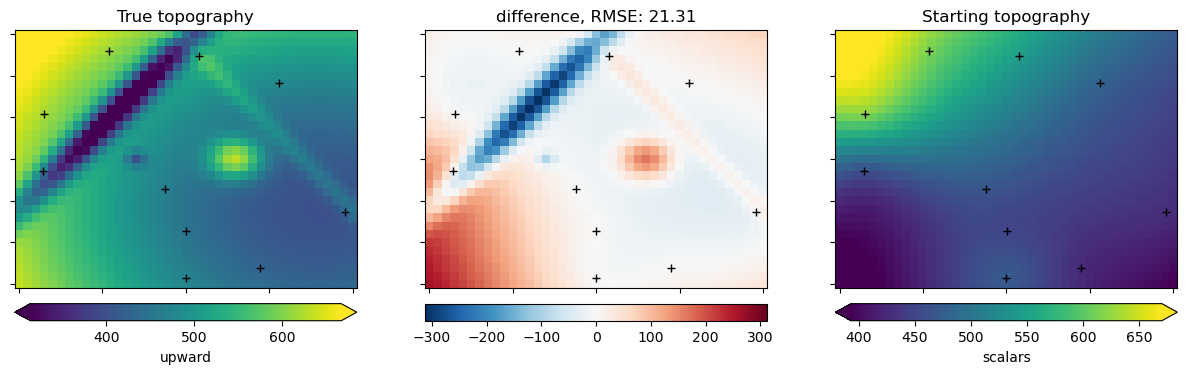

In [4]:
_ = ap_utils.grd_compare(
    true_topography,
    starting_topography,
    plot_type="xarray",
    plot=True,
    grid1_name="True topography",
    grid2_name="Starting topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    # reverse_cpt=True,
    # cmap="rain",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
)

### Prism layer

In [5]:
# the density contrast is between rock (~2670 kg/m3) and air (~1 kg/m3)
density_contrast = 2670 - 1

# prisms are created between the mean topography value and the height of the topography
zref = true_topography.values.mean()

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density = xr.where(true_topography >= zref, density_contrast, -density_contrast)

# create layer of prisms
prisms = utils.grids_to_prisms(
    true_topography,
    zref,
    density=density,
)

### Forward gravity of prism layer

In [6]:
# make pandas dataframe of locations to calculate gravity
# create lists of coordinates
coords = vd.grid_coordinates(
    region=region,
    spacing=spacing,
    pixel_register=False,
    extra_coords=1000,
)

# grid the coordinates
observations = vd.make_xarray_grid(
    (coords[0], coords[1]),
    data=coords[2],
    data_names="upward",
    dims=("northing", "easting"),
).upward

grav_df = vd.grid_to_table(observations)

grav_df["observed_grav"] = prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)
grav_df

  0%|          | 0/1271 [00:00<?, ?it/s]

,northing,easting,upward,observed_grav
0,0.0,0.0,1000.0,9.534643
1,0.0,1000.0,1000.0,10.422834
2,0.0,2000.0,1000.0,9.949973
3,0.0,3000.0,1000.0,9.269279
4,0.0,4000.0,1000.0,8.532160
...,...,...,...,...
1266,30000.0,36000.0,1000.0,3.332716
1267,30000.0,37000.0,1000.0,3.330307
1268,30000.0,38000.0,1000.0,3.335438
1269,30000.0,39000.0,1000.0,3.300721


## Gravity misfit
Now we need to calculate the forward gravity of the starting topography. We then can subtract it from our observed gravity to get a starting gravity misfit.

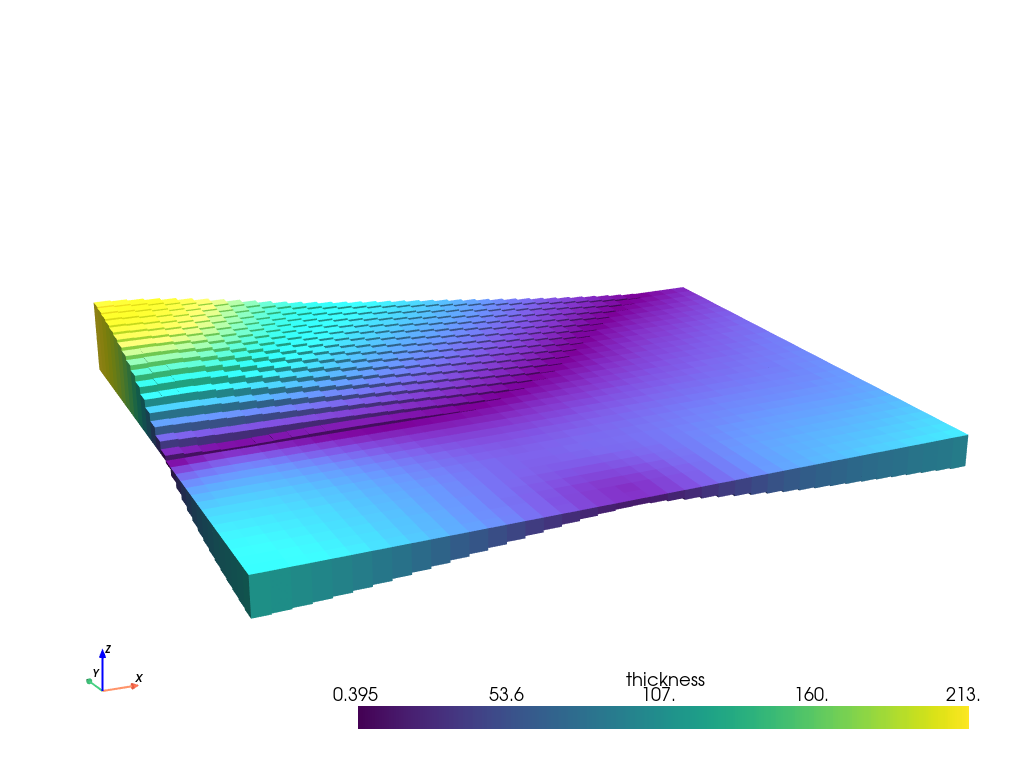

In [7]:
# set the reference level of the starting topography to be mean of the grid
# this may not be accurate, especially if the starting topography has few constraints
zref = starting_topography.values.mean()

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density = xr.where(starting_topography >= zref, density_contrast, -density_contrast)

# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_topography,
    zref,
    density=density,
)

plotting.show_prism_layers(
    starting_prisms,
    color_by="thickness",
    log_scale=False,
    zscale=20,
    backend="static",
)

In [8]:
# calculate forward gravity of starting prism layer
grav_df["starting_grav"] = starting_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)

# calculate misfit as observed - starting
grav_df["misfit"] = grav_df["observed_grav"] - grav_df["starting_grav"]

# in many cases, we want to remove a regional signal from the misfit to isolate the
# residual signal. In this simple case, we assume there is no regional misfit and the
# full misfit is equal to the residual misfit.

# set regional misfit to 0
grav_df["reg"] = 0

# set the residual misfit to the full misfit
grav_df["res"] = grav_df.misfit

grav_df

  0%|          | 0/1271 [00:00<?, ?it/s]

,northing,easting,upward,observed_grav,starting_grav,misfit,reg,res
0,0.0,0.0,1000.0,9.534643,-6.537446,16.072089,0,16.072089
1,0.0,1000.0,1000.0,10.422834,-7.742933,18.165768,0,18.165768
2,0.0,2000.0,1000.0,9.949973,-7.851638,17.801611,0,17.801611
3,0.0,3000.0,1000.0,9.269279,-7.723797,16.993076,0,16.993076
4,0.0,4000.0,1000.0,8.532160,-7.492407,16.024567,0,16.024567
...,...,...,...,...,...,...,...,...
1266,30000.0,36000.0,1000.0,3.332716,-0.019163,3.351879,0,3.351879
1267,30000.0,37000.0,1000.0,3.330307,-0.297847,3.628154,0,3.628154
1268,30000.0,38000.0,1000.0,3.335438,-0.557034,3.892471,0,3.892471
1269,30000.0,39000.0,1000.0,3.300721,-0.776698,4.077419,0,4.077419


## Perform inversion
Now that we have a starting model and residual gravity misfit data we can start the inversion.

INFO:root:starting inversion


INFO:root:extracted prism spacing is 1000.0
INFO:root:
 #################################### 
 iteration 1
INFO:root:Layer correction median: -4.2305 m, RMSE:33.2223 m
INFO:root:updated misfit RMSE: 3.9908
INFO:root:updated L2-norm: 1.9977, tolerance: 0.3
INFO:root:updated delta L2-norm : 1.3303, tolerance: 1.01
INFO:root:
 #################################### 
 iteration 2
INFO:root:Layer correction median: 0.6478 m, RMSE:18.5175 m
INFO:root:updated misfit RMSE: 2.3411
INFO:root:updated L2-norm: 1.5301, tolerance: 0.3
INFO:root:updated delta L2-norm : 1.3056, tolerance: 1.01
INFO:root:
 #################################### 
 iteration 3
INFO:root:Layer correction median: 2.1331 m, RMSE:10.5716 m
INFO:root:updated misfit RMSE: 1.4478
INFO:root:updated L2-norm: 1.2033, tolerance: 0.3
INFO:root:updated delta L2-norm : 1.2716, tolerance: 1.01
INFO:root:
 #################################### 
 iteration 4
INFO:root:Layer correction median: 1.5109 m, RMSE:6.2951 m
INFO:root:updated misfit R

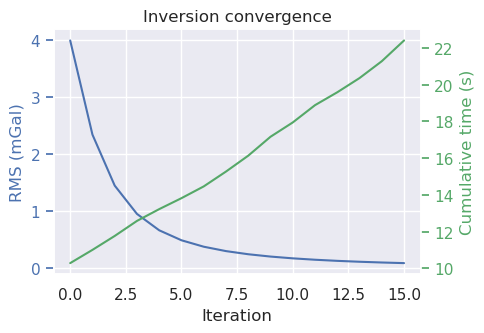

In [9]:
# set Python's logging level to get information about the inversion\s progress
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# run the inversion
results = inversion.run_inversion(
    input_grav=grav_df,
    input_grav_column="observed_grav",
    prism_layer=starting_prisms,
    zref=zref,
    density_contrast=density_contrast,
    # display the convergence of the inversion
    plot_convergence=True,
    # choose the small prism approximation method for calculating the vertical
    # derivative of gravity
    deriv_type="annulus",
    solver_damping=0.1,
    # set stopping criteria
    max_iterations=30,
    l2_norm_tolerance=0.3,
    delta_l2_norm_tolerance=1.01,
)

# collect the results
topo_results, grav_results, parameters, elapsed_time = results

returning original grid
returning original grid


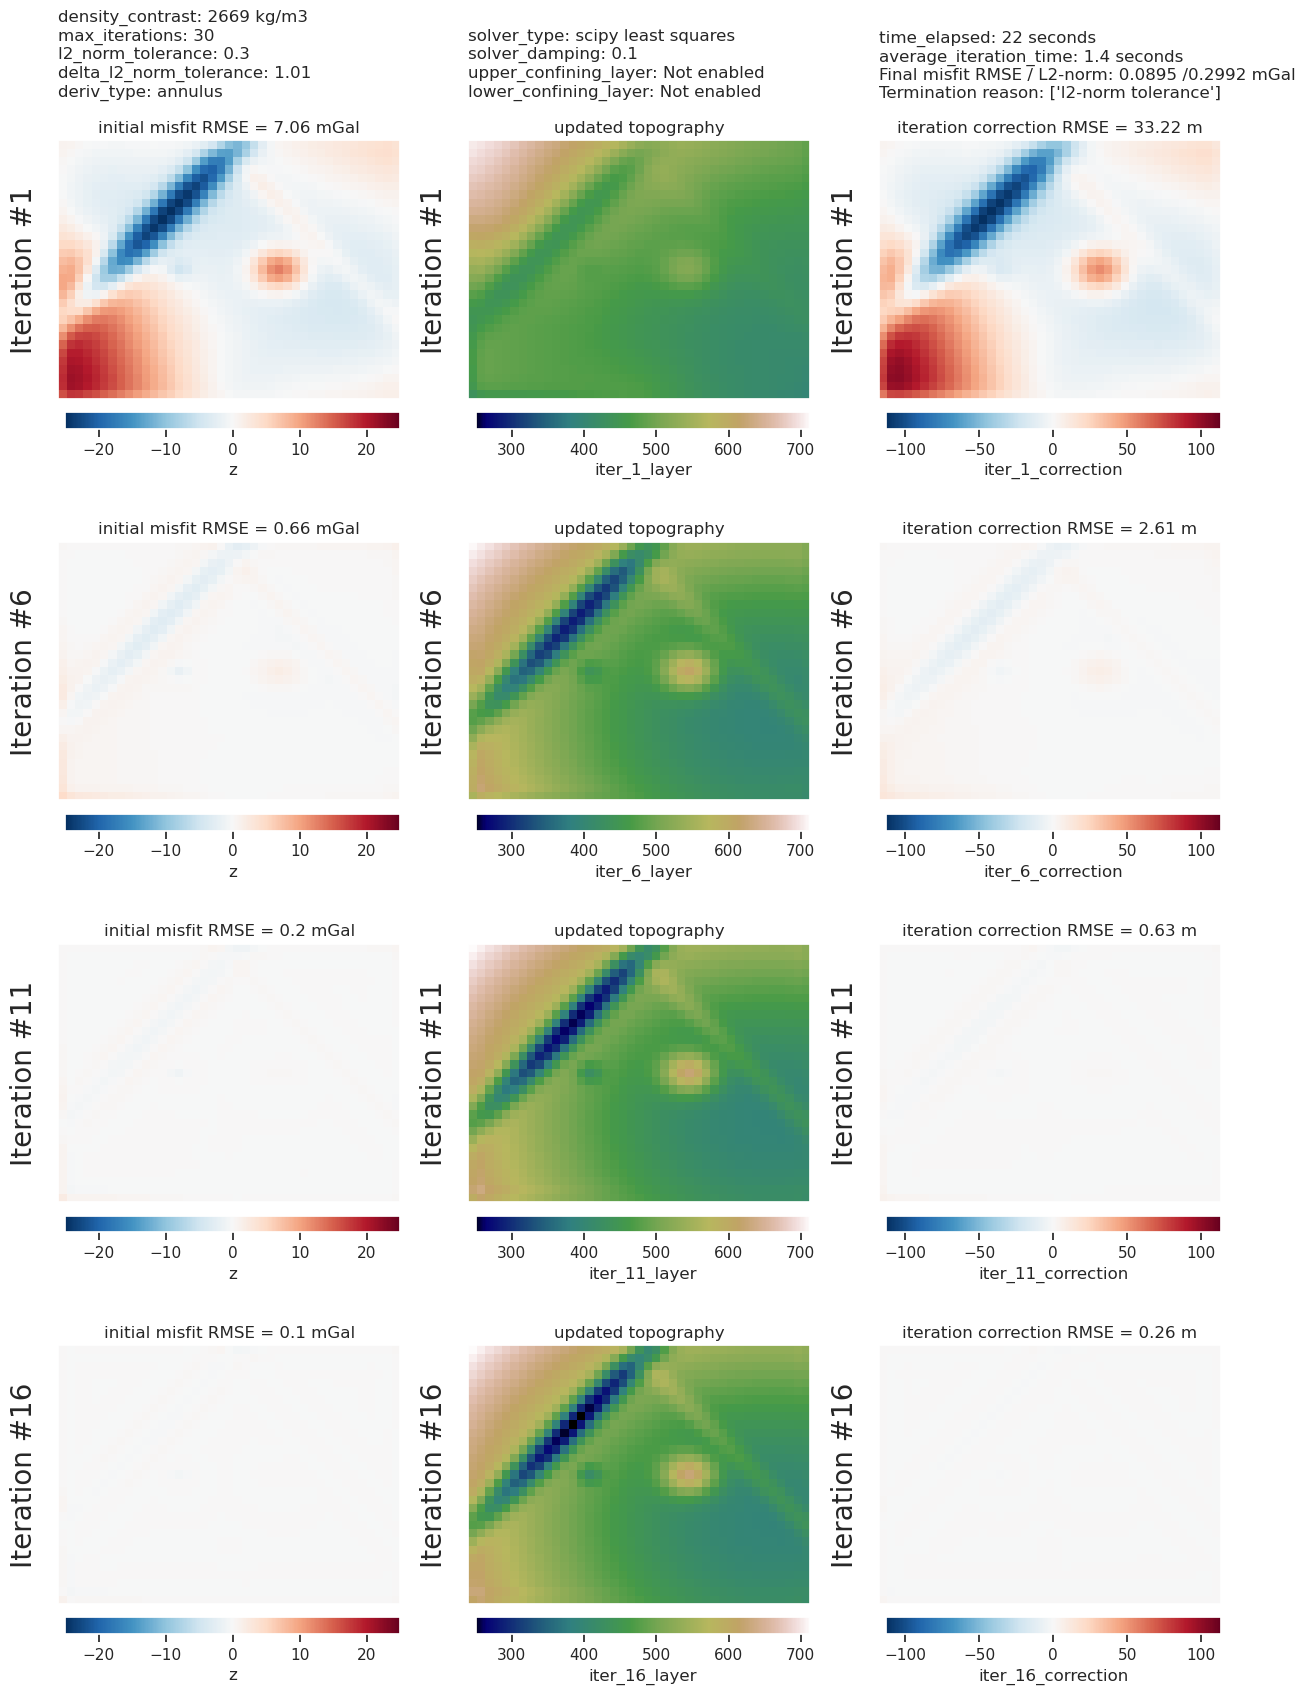

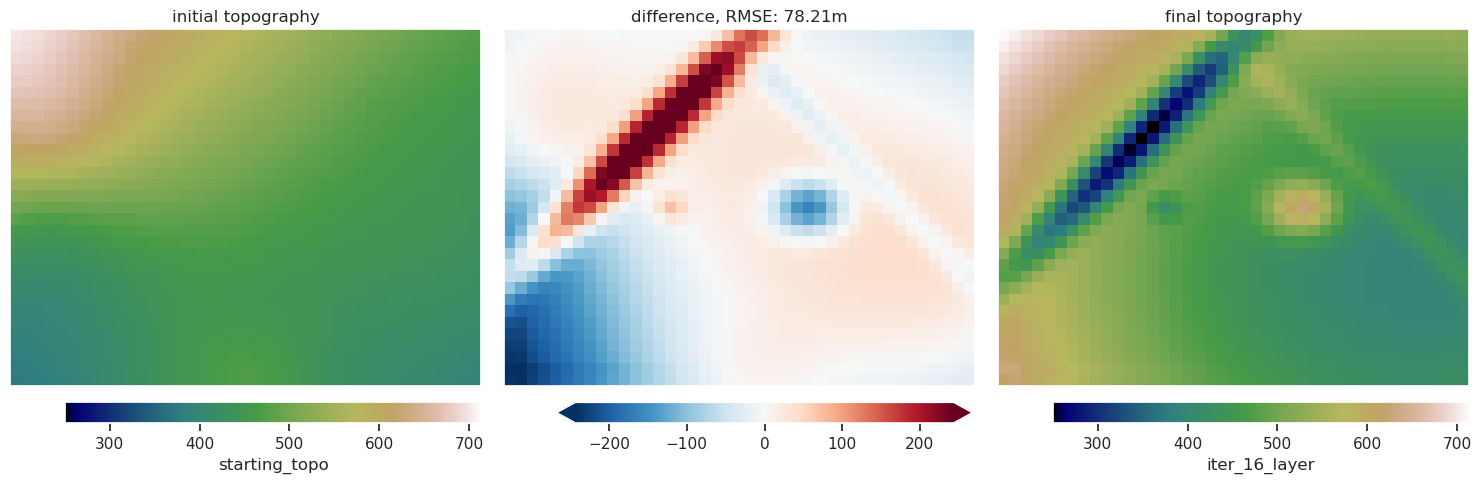

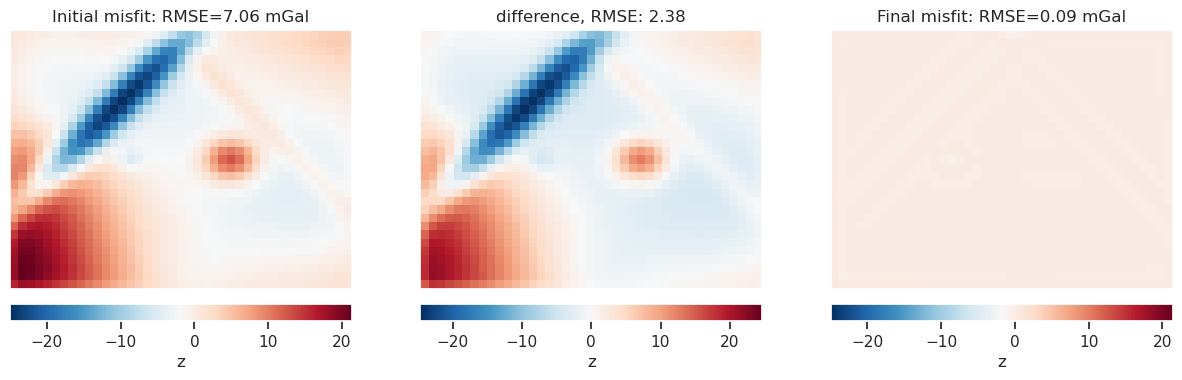

In [10]:
plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    region,
    spacing,
    iters_to_plot=4,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
)

returning original grid
returning original grid


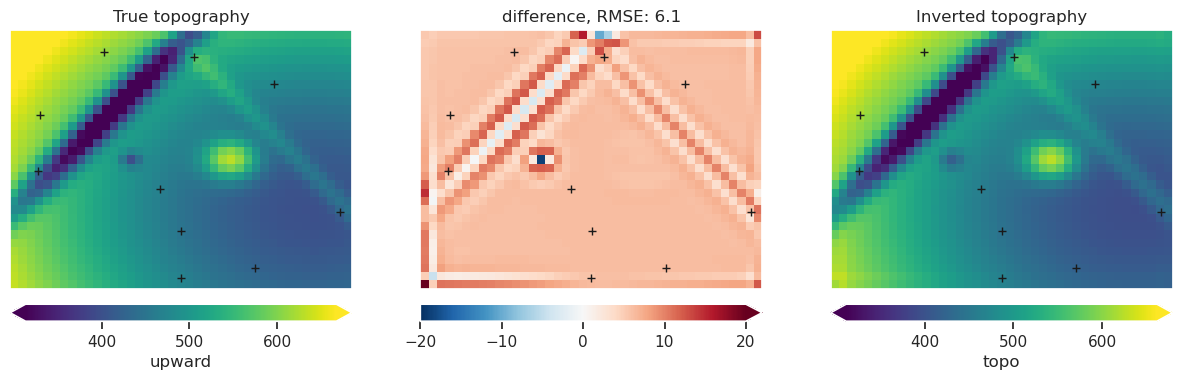

In [11]:
final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = ap_utils.grd_compare(
    true_topography,
    final_topography,
    plot_type="xarray",
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    # reverse_cpt=True,
    # cmap="rain",
    diff_lims=(-20, 20),
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
)

The inverted topography is vertically offset from the true topography by ~ 6 m. This is because the    reference level (`zref`) we used was the mean of the starting topography, which is not exactly equal to the true reference level. The notebook `reference_level_cross_validation.ipynb` presents a method to chose an appropriate value of `zref`.

In [12]:
# sample the inverted topography at the constraint points
constraint_points = utils.sample_grids(
    constraint_points,
    final_topography,
    "inverted_topography",
    coord_names=("easting", "northing"),
)

rmse = utils.rmse(constraint_points.upward - constraint_points.inverted_topography)
print(f"RMSE: {rmse:.2f} m")

RMSE: 6.62 m


The RMSE between the constraint's true values and the inverted topography at the constraint's is ~ 7 m. This shows that while the starting model helped the inversion, the actual values of the constraints is not adhered too. The next inversion (`adhering_to_constraints.ipynb`) will show how to help the model stick to the constraints. 

#